# Exploration of Dimension Reduction
<span style="font-weight:bold; font-size:17pt; color:#666666;">XGBoost for feature selection</span>
<hr>

This notebook is for EDA, feature extraction, engineering and the subsequent evaluation of XGBoost as a dimension reduction technique.

The input (**sampled_data.h5**) for this notebook is generated by **_centroid_sampling.ipynb_**.

It assumes the data (**sampled_data.h5.h5**, the sampled set) is in a sub-directory of the **/data** folder. I've already added entries to the _.gitignore_ file so that they won't be committed to the repository. Note that this file should be updated for new versions of the data.

See the [data readme in the Gitbug repository](https://github.com/BrianDavisMath/FDA-COVID19/tree/master/data) for more details.

<hr>

In [19]:
%pylab inline
%autosave 25

import h5py
import random
import pandas as pd

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Data location

Change this when you get a new data set.

In [3]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

## Load the data from sampled_data.h5
<hr>

In [4]:
store = pd.HDFStore(data_loc + 'sampled_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

rows: 22,172, columns: 17,076


## Experiment 1

XGBoost for features extraction.

* determine number of epochs for training XGBoost
* grid/random search parameter space to finie tune parameters
* return the top 1,000 features, according to gain, as a candidate set

# XGBoost

reference material:

* [An End-to-End Guide to Understand the Math behind XGBoost](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/)
* [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
* [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
*[Python's Xgoost: ValueError('feature_names may not contain \[, \] or \<')](https://stackoverflow.com/questions/48645846/pythons-xgoost-valueerrorfeature-names-may-not-contain-or/50633571)
* [Fine-tuning XGBoost in Python like a boss](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

### Fix column names

#### XGBoost does not like <>, [] and , in column names

In [6]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_features.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_features.columns.values]

In [7]:
Y = df_features['activity'].values
X = df_features.drop(['activity', 'cid', 'pid'], axis=1)

## XGBoost parameter tuning

Play around with fitting a model and see if we can narrow down the parameter search space for subsequent fine tuning.

reference material:

* [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
* [A Gentle Introduction to Early Stopping to Avoid Overtraining Neural Networks](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/)
* [Stackoverflow: Training Error is Lower than Testing error in a Random Forest Model](https://stackoverflow.com/questions/53420692/training-error-is-lower-than-testing-error-in-a-random-forest-model)

### First evaluation

Accuracy: 82.47%


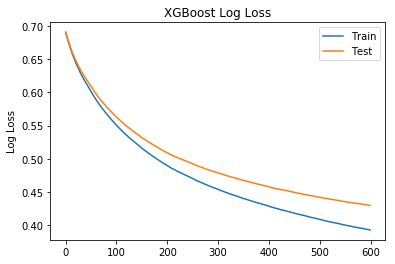

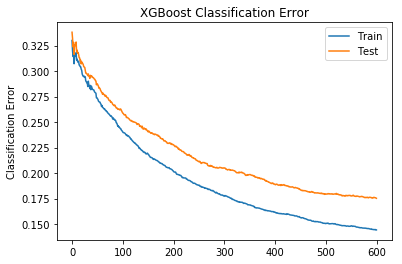

In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# fit model to training data
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

xgb.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=50)

# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

### Grid search to find number of epochs (n_estimators)

set of n_estimators to test: [400, 600, 800, 1000]
Best: -0.400866 using {'n_estimators': 1000}
-0.461133 (0.002936) with: {'n_estimators': 400}
-0.432493 (0.002881) with: {'n_estimators': 600}
-0.414401 (0.002292) with: {'n_estimators': 800}
-0.400866 (0.001770) with: {'n_estimators': 1000}


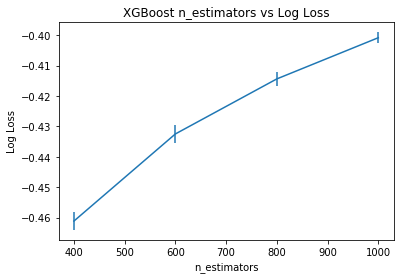

In [9]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic', silent=True, nthread=1)

n_estimators = range(400, 1200, 200) # try different numbers of epochs

print('set of n_estimators to test: {}'.format([x for x in n_estimators]))

param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

#### Save the best model

In [12]:
joblib.dump(grid_search.best_estimator_, data_loc + 'best_estimator_model.mdl')

['../data/FDA-COVID19_files_v1.0/best_estimator_model.mdl']

#### Load the best model

In [24]:
mdl = joblib.load(data_loc + 'best_estimator_model.mdl')

#### Check accuracy

In [27]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# make predictions for test data
y_pred = grid_search.best_estimator_.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.22%


### View top features

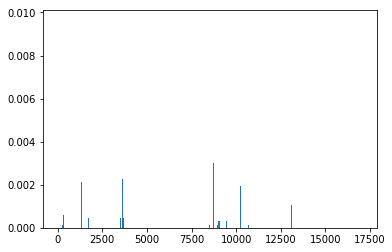

number of non-zero importance values for features is 1,229


In [59]:
pyplot.bar(range(len(mdl.feature_importances_)), mdl.feature_importances_)
pyplot.show()

non_zero = np.nonzero(mdl.feature_importances_)[0]
print('number of non-zero importance values for features is {:,}'.format(len(non_zero)))

In [79]:
# Get importance as information gain (the improvement in accuracy brought by a feature).
gain_importance = mdl.get_booster().get_score(importance_type="gain")

In [85]:
# Compare weight vs gain importance in returned features
non_zero_weight_keys = np.array(df_features.columns.tolist())[non_zero]

features_in_common = [f for f in non_zero_weight_keys if f in gain_importance]

print('There are {:,} in common between those with highest weight and those with highest gain.'.format(len(features_in_common)))

There are 441 in common between those with highest weight and those with highest gain.


### Early stopping to refine number of epochs

It is suggested that a sensible early stoppinig parameter is 10% of _n_estimators_.

## Randomized hyperparameter space search

Now we have an idea about the number of epochs to use lets carry out a parameter search to refine the other parameters.

reference material:

* [Kaggle: Hyperparameter Grid Search with XGBoost](https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost)
* [Hi I’m Gamma. What can I do for you?](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6)

### Define a timer

In [21]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


### Set up the hyperparameter space

In [22]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

### run XGBoost

In [23]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(X,Y), 
    verbose=3, 
    random_state=1001)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
random_search.best_params_

### Feature importance

Can use **_random_search.best_estimator\__** from above to get the most important features according to gain.

reference material:

* [The Multiple faces of ‘Feature importance’ in XGBoost](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)